In [3]:
import numpy as np
import xarray as xr

import datetime as dt
import pandas as pd

import matplotlib.pyplot as plt

import altair as alt
alt.data_transformers.enable('json')

from sublimpy import utils
import glob
import pytz
from scipy.signal import welch, csd
from scipy.stats import chi2

# Load Tidy Dataset

In [4]:
start_date = '20221130'
end_date = '20230508'
# open files
# tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit_clean.parquet')
# tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_planar_fit_multiplane.parquet')
tidy_df = pd.read_parquet(f"process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_q7_flags9000_pf10.parquet")
# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
tidy_df = utils.modify_df_timezone(tidy_df, pytz.UTC, 'US/Mountain')
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds
tidy_df = tidy_df.set_index('time').sort_index().loc[
    '20221130':'20230508'
].reset_index()

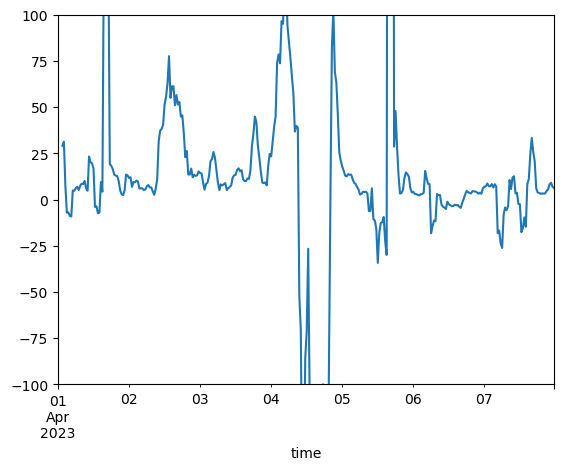

In [5]:
# Identify lists of timestamps for different categories
bs_times = list(pd.to_datetime(list(set(
    tidy_df.query("variable == 'SF_avg_1m_ue'").query("value > 0").time
).union(
    set(tidy_df.query("variable == 'SF_avg_2m_ue'").query("value > 0").time)
))))
nobs_times = list(pd.to_datetime(list(set(tidy_df.time).difference(bs_times))))

decoupled_times = list(pd.to_datetime(tidy_df.query("variable == 'omega_3m_c'").query("value < 0.43").time))
weaklycoupled_times = list(pd.to_datetime(tidy_df.query("variable == 'omega_3m_c'").query("value >= 0.43").query("value <= 0.61").time))
coupled_times = list(pd.to_datetime(tidy_df.query("variable == 'omega_3m_c'").query("value > 0.61").time))

ri_stable_times = list(pd.to_datetime(tidy_df.query("variable == 'Ri_3m_c'").query("value > 0.25").time))
ri_unstable_times = list(pd.to_datetime(tidy_df.query("variable == 'Ri_3m_c'").query("value < -0.01").time))
ri_neutral_times = list(pd.to_datetime(tidy_df.query("variable == 'Ri_3m_c'").query("value >= -0.01").query("value <= 0.25").time))

tgrad_stable_times = list(pd.to_datetime(tidy_df.query("variable == 'temp_gradient_3m_c'").query("value > 0.01").time))
tgrad_unstable_times = list(pd.to_datetime(tidy_df.query("variable == 'temp_gradient_3m_c'").query("value < -0.01").time))
tgrad_neutral_times = list(pd.to_datetime(tidy_df.query("variable == 'temp_gradient_3m_c'").query("value >= -0.01").query("value <= 0.01").time))

upvalley_wind_times = list(pd.to_datetime(tidy_df[tidy_df.variable == 'dir_3m_c'].query("value < 152").query("value > 92").time.values))
downvalley_wind_times = list(pd.to_datetime(tidy_df[tidy_df.variable == 'dir_3m_c'].query("value < 342").query("value > 292").time.values))

downvalley_nobs_times = set(downvalley_wind_times).intersection(set(nobs_times))
upvalley_nobs_times = set(upvalley_wind_times).intersection(set(nobs_times))

len(upvalley_wind_times),len(downvalley_wind_times)


src = tidy_df[tidy_df.variable.isin(['u*_3m_c', 'Tsurfvirtual_c', 'Tvirtual_1m_c', 'Tvirtual_2m_c', 'Tvirtual_3m_c','w_tc__3m_c',])].pivot_table(index='time', columns='variable', values='value')
src['Tvirtual_avg'] = src[['Tsurfvirtual_c', 'Tvirtual_3m_c']].mean(axis=1)
l_3m_c = - (src['u*_3m_c']**3)*(src['Tvirtual_avg']+273.15) / (0.4 * 9.81 * src['w_tc__3m_c'])
# tidy_df[tidy_df.variable == 'L_3m_c'].set_index('time').loc['20230201': '20230207'].value.plot()
l_3m_c.loc['20230401': '20230407'].rolling(4).mean().plot()
import matplotlib.pyplot as plt
plt.ylim(-100,100)
z_over_L_3m_c = 3 / l_3m_c
z_over_L_stable_times = z_over_L_3m_c[z_over_L_3m_c > 0.05].index
z_over_L_neutral_times = z_over_L_3m_c[(z_over_L_3m_c <= 0.05) & (z_over_L_3m_c >= -0.05)].index
z_over_L_unstable_times = z_over_L_3m_c[z_over_L_3m_c < -0.05].index

# Load MRDs

In [6]:
ls /Users/elischwat/Development/data/sublimationofsnow/mrd/

0800_1200/ 0900_1700/ 1200_1600/ 1900_0500/


In [7]:
!find /Users/elischwat/Development/data/sublimationofsnow/mrd/ -type d

/Users/elischwat/Development/data/sublimationofsnow/mrd/
/Users/elischwat/Development/data/sublimationofsnow/mrd//0800_1200
/Users/elischwat/Development/data/sublimationofsnow/mrd//0800_1200/sensible_heat
/Users/elischwat/Development/data/sublimationofsnow/mrd//0800_1200/latent_heat
/Users/elischwat/Development/data/sublimationofsnow/mrd//1200_1600
/Users/elischwat/Development/data/sublimationofsnow/mrd//1200_1600/sensible_heat
/Users/elischwat/Development/data/sublimationofsnow/mrd//1200_1600/latent_heat
/Users/elischwat/Development/data/sublimationofsnow/mrd//0900_1700
/Users/elischwat/Development/data/sublimationofsnow/mrd//0900_1700/sensible_heat
/Users/elischwat/Development/data/sublimationofsnow/mrd//0900_1700/latent_heat
/Users/elischwat/Development/data/sublimationofsnow/mrd//1900_0500
/Users/elischwat/Development/data/sublimationofsnow/mrd//1900_0500/sensible_heat
/Users/elischwat/Development/data/sublimationofsnow/mrd//1900_0500/latent_heat


In [8]:
sh_mrds = pd.read_parquet("/Users/elischwat/Development/data/sublimationofsnow/mrd/0900_1700/sensible_heat")
lh_mrds = pd.read_parquet("/Users/elischwat/Development/data/sublimationofsnow/mrd/0900_1700/latent_heat")

sh_mrds = sh_mrds[(sh_mrds['date'] >= '20221130') & (sh_mrds['date'] < '20230509')]
lh_mrds = lh_mrds[(lh_mrds['date'] >= '20221130') & (lh_mrds['date'] < '20230509')]
sh_mrds.head(3), lh_mrds.head(3)

(   tau        Co       std    var1     var2  height tower      date
 0  0.1 -0.000100  0.001681  w_2m_c  tc_2m_c       2     c  20221130
 1  0.2 -0.000155  0.002026  w_2m_c  tc_2m_c       2     c  20221130
 2  0.4 -0.000219  0.002556  w_2m_c  tc_2m_c       2     c  20221130,
    tau        Co       std    var1      var2  height tower      date
 0  0.1 -0.000001  0.000144  w_2m_c  h2o_2m_c       2     c  20221130
 1  0.2 -0.000004  0.000176  w_2m_c  h2o_2m_c       2     c  20221130
 2  0.4 -0.000009  0.000239  w_2m_c  h2o_2m_c       2     c  20221130)

### Calculate daily mean sensible heat flux to categorize each day as stable/unstable

In [9]:
shflux_3m = tidy_df.query("variable == 'w_tc__3m_c'")
shflux_3m['date_str'] = shflux_3m.time.dt.strftime('%Y%m%d')
shflux_3m = shflux_3m[shflux_3m.date_str.isin(sh_mrds.date)]
shflux_3m = shflux_3m[shflux_3m.time.dt.hour.isin([9,10,11,12,13,14,15,16])]
shflux_3m = shflux_3m.groupby('date_str').value.mean()
shflux_3m

alt.Chart(pd.DataFrame(shflux_3m)).mark_bar().encode(
    alt.X('value:Q').bin(True), alt.Y('count():Q')
    
) + alt.Chart(pd.DataFrame(shflux_3m)).mark_text(yOffset=-8).encode(
    alt.X('value:Q').bin(True), 
    alt.Y('count():Q'),
    alt.Text('count()'),
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_39695/4095707620.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shflux_3m['date_str'] = shflux_3m.time.dt.strftime('%Y%m%d')


alt.LayerChart(...)

### Calculate daily mean BS flux to categorize each day as BS/no-BS

In [11]:
bs_flux_1m = tidy_df.query("variable == 'SF_avg_1m_ue'")
bs_flux_2m = tidy_df.query("variable == 'SF_avg_2m_ue'")
bsflux_df = pd.DataFrame(pd.DataFrame(bs_flux_1m.set_index('time')['value'].rename('bs_flux_1m')).join(
    bs_flux_2m.set_index('time')['value'].rename('bs_flux_2m')
).sum(axis=1).rename('bs_flux'))
bsflux_df['date_str'] = bsflux_df.index.strftime('%Y%m%d')
bsflux_df = bsflux_df[bsflux_df.date_str.isin(sh_mrds.date)]
bsflux_df = bsflux_df[bsflux_df.index.hour.isin([9,10,11,12,13,14,15,16])]
bsflux_df = bsflux_df.groupby('date_str')[['bs_flux']].mean()
bsflux_df['is_bs_day'] = bsflux_df['bs_flux'] > 0
alt.Chart(bsflux_df).mark_bar().encode(
    alt.X('is_bs_day:N'),
    alt.Y('count()')
)

alt.Chart(...)

In [12]:
sh_mrds = sh_mrds.merge(
    shflux_3m.rename('w_tc__3m_c'),
    how='left',
    left_on='date',
    right_on='date_str'
)
lh_mrds = lh_mrds.merge(
    shflux_3m.rename('w_tc__3m_c'),
    how='left',
    left_on='date',
    right_on='date_str'
)

## Analysis

### Composite analysis of Cospectra

#### Stable vs Unstable conditions

In [13]:
def q1(x):
    return x.quantile(0.25)

def q3(x):
    return x.quantile(0.75)

In [14]:
line = alt.Chart().transform_calculate(y = '0').mark_rule(color='black').encode(y='y:Q')

src = sh_mrds[sh_mrds.height.isin([3,5, 10, 15, 20])].query("tower == 'c'")
src['stability'] = src['w_tc__3m_c'].apply(lambda w_tc_: 'stable' if w_tc_ < 0 else 'unstable')
median_src = pd.DataFrame(src.groupby(['tau', 'height', 'tower', 'stability'])['Co'].median())
stddev_src = pd.DataFrame(src.groupby(['tau', 'height', 'tower', 'stability'])['Co'].std())
quantiles_src = pd.DataFrame(src.groupby(['tau', 'height', 'tower', 'stability'])['Co'].agg([q1, q3]))
median_src = median_src.rename(columns={'Co': 'Co median'})
stddev_src = stddev_src.rename(columns={'Co': 'Co std'})
src = median_src.join(stddev_src).join(quantiles_src).reset_index()

src['Co lower'] = src['Co median'] - src['Co std']
src['Co upper'] = src['Co median'] + src['Co std']

shflux_chart = alt.layer(
    alt.Chart().mark_rule(strokeDash=[2,2], color='black').transform_calculate(
        x = '1800'
    ).encode(alt.X('x:Q').title('')),
    alt.Chart().mark_errorband().encode(
        alt.X('tau:Q').scale(type='log').title('𝜏 (s)'),
        alt.Y('q1:Q').scale(domain=[-0.0025,0.0025], clamp=True).title("Co(w'T')"),
        alt.Y2('q3:Q'),
        alt.Color('stability:N')
    ),
    alt.Chart().mark_line().encode(
        alt.X('tau:Q').scale(type='log'),
        alt.Y('Co median:Q').scale(domain=[-0.0025,0.0025], clamp=True).title("Co(w'T')"),
        alt.Color('stability:N')
    ),
    line,
    data = src
).properties(height = 100, width = 200).facet(
    'height:O'
).properties(title='Sensible heat flux, multiresolution decomposition')

In [15]:
line = alt.Chart().transform_calculate(y = '0').mark_rule(color='black').encode(y='y:Q')

seasonal_lhflux_mrd_src = lh_mrds[lh_mrds.height.isin(
    [2, 3,5, 10, 15, 20]
)].query("tower == 'c'")
seasonal_lhflux_mrd_src['stability'] = seasonal_lhflux_mrd_src['w_tc__3m_c'].apply(lambda w_tc_: 'stable' if w_tc_ < 0 else 'unstable')
median_seasonal_lhflux_mrd_src = pd.DataFrame(seasonal_lhflux_mrd_src.groupby(['tau', 'height', 'tower', 'stability'])['Co'].median())
quantiles_seasonal_lhflux_mrd_src = pd.DataFrame(seasonal_lhflux_mrd_src.groupby(['tau', 'height', 'tower', 'stability'])['Co'].agg([q1, q3]))
median_seasonal_lhflux_mrd_src = median_seasonal_lhflux_mrd_src.rename(columns={'Co': 'Co median'})
seasonal_lhflux_mrd_src = median_seasonal_lhflux_mrd_src.join(quantiles_seasonal_lhflux_mrd_src).reset_index()

lhflux_chart = alt.layer(
    alt.Chart().mark_rule(strokeDash=[2,2], color='black').transform_calculate(
        x = '1800'
    ).encode(alt.X('x:Q').title('')),
    alt.Chart().mark_errorband().encode(
        alt.X('tau:Q').scale(type='log').title('𝜏 (s)'),
        alt.Y('q1:Q').scale().title("Co(w'q')"),
        alt.Y2('q3:Q'),
        alt.Color('stability:N')
    ),
    alt.Chart().mark_line().encode(
        alt.X('tau:Q').scale(type='log'),
        alt.Y('Co median:Q').scale().title("Co(w'q')"),
        alt.Color('stability:N')
    ),
    line,
    data = seasonal_lhflux_mrd_src
).properties(height = 150, width = 150).facet(
    'height:O', columns=3
).properties(title='Latent heat flux, multiresolution decomposition')

In [16]:
lhflux_chart.display(renderer='svg')

alt.FacetChart(...)

In [17]:
line = alt.Chart().transform_calculate(y = '0').mark_rule(color='black').encode(y='y:Q')

lh_mrds_with_bs = lh_mrds.merge(
    bsflux_df.reset_index().rename(columns={'date_str': 'date'}),
    on='date'
)
lh_mrds_with_bs = lh_mrds_with_bs[ lh_mrds_with_bs.is_bs_day ]

seasonal_lhflux_mrd_src = lh_mrds_with_bs[lh_mrds_with_bs.height.isin(
    [2, 3,5, 10, 15, 20]
)].query("tower == 'c'")
seasonal_lhflux_mrd_src['stability'] = seasonal_lhflux_mrd_src['w_tc__3m_c'].apply(lambda w_tc_: 'stable' if w_tc_ < 0 else 'unstable')
median_seasonal_lhflux_mrd_src = pd.DataFrame(seasonal_lhflux_mrd_src.groupby(['tau', 'height', 'tower', 'stability'])['Co'].median())
quantiles_seasonal_lhflux_mrd_src = pd.DataFrame(seasonal_lhflux_mrd_src.groupby(['tau', 'height', 'tower', 'stability'])['Co'].agg([q1, q3]))
median_seasonal_lhflux_mrd_src = median_seasonal_lhflux_mrd_src.rename(columns={'Co': 'Co median'})
seasonal_lhflux_mrd_src = median_seasonal_lhflux_mrd_src.join(quantiles_seasonal_lhflux_mrd_src).reset_index()

alt.layer(
    alt.Chart().mark_rule(strokeDash=[2,2], color='black').transform_calculate(
        x = '1800'
    ).encode(alt.X('x:Q').title('')),
    alt.Chart().mark_errorband().encode(
        alt.X('tau:Q').scale(type='log').title('𝜏 (s)'),
        alt.Y('q1:Q').scale().title("Co(w'q')"),
        alt.Y2('q3:Q'),
        alt.Color('stability:N')
    ),
    alt.Chart().mark_line().encode(
        alt.X('tau:Q').scale(type='log'),
        alt.Y('Co median:Q').scale().title("Co(w'q')"),
        alt.Color('stability:N')
    ),
    line,
    data = seasonal_lhflux_mrd_src
).properties(height = 150, width = 150).facet(
    'height:O', columns=3
).properties(title='Latent heat flux, multiresolution decomposition, during BS')

alt.FacetChart(...)

In [18]:
line = alt.Chart().transform_calculate(y = '0').mark_rule(color='black').encode(y='y:Q')

lh_mrds_with_bs = lh_mrds.merge(
    bsflux_df.reset_index().rename(columns={'date_str': 'date'}),
    on='date'
)
lh_mrds_with_bs = lh_mrds_with_bs[ ~ lh_mrds_with_bs.is_bs_day ]

seasonal_lhflux_mrd_src = lh_mrds_with_bs[lh_mrds_with_bs.height.isin(
    [2, 3,5, 10, 15, 20]
)].query("tower == 'c'")
seasonal_lhflux_mrd_src['stability'] = seasonal_lhflux_mrd_src['w_tc__3m_c'].apply(lambda w_tc_: 'stable' if w_tc_ < 0 else 'unstable')
median_seasonal_lhflux_mrd_src = pd.DataFrame(seasonal_lhflux_mrd_src.groupby(['tau', 'height', 'tower', 'stability'])['Co'].median())
quantiles_seasonal_lhflux_mrd_src = pd.DataFrame(seasonal_lhflux_mrd_src.groupby(['tau', 'height', 'tower', 'stability'])['Co'].agg([q1, q3]))
median_seasonal_lhflux_mrd_src = median_seasonal_lhflux_mrd_src.rename(columns={'Co': 'Co median'})
seasonal_lhflux_mrd_src = median_seasonal_lhflux_mrd_src.join(quantiles_seasonal_lhflux_mrd_src).reset_index()

alt.layer(
    alt.Chart().mark_rule(strokeDash=[2,2], color='black').transform_calculate(
        x = '1800'
    ).encode(alt.X('x:Q').title('')),
    alt.Chart().mark_errorband().encode(
        alt.X('tau:Q').scale(type='log').title('𝜏 (s)'),
        alt.Y('q1:Q').scale().title("Co(w'q')"),
        alt.Y2('q3:Q'),
        alt.Color('stability:N')
    ),
    alt.Chart().mark_line().encode(
        alt.X('tau:Q').scale(type='log'),
        alt.Y('Co median:Q').scale().title("Co(w'q')"),
        alt.Color('stability:N')
    ),
    line,
    data = seasonal_lhflux_mrd_src
).properties(height = 150, width = 150).facet(
    'height:O', columns=3
).properties(title='Latent heat flux, multiresolution decomposition, during NO BS')

alt.FacetChart(...)

In [19]:
print(len(lh_mrds[['date', 'w_tc__3m_c']].drop_duplicates().query("w_tc__3m_c > 0")))
print(len(lh_mrds[['date', 'w_tc__3m_c']].drop_duplicates().query("w_tc__3m_c < 0")))
print(len(lh_mrds[['date', 'w_tc__3m_c']].drop_duplicates().query("w_tc__3m_c == 0")))

46
114
0


In [20]:
(shflux_chart & lhflux_chart)

alt.VConcatChart(...)

#### No BS conditions

In [21]:
nobs_days = pd.Series(nobs_times)
nobs_days = nobs_days[nobs_days.dt.hour >= 9]
nobs_days = nobs_days[nobs_days.dt.hour < 17]
nobs_days = nobs_days.dt.date.value_counts()
nobs_days = nobs_days[nobs_days == 16]
nobs_days = nobs_days.index.to_series().astype('str').apply(lambda s: s.replace('-', ''))
nobs_days = nobs_days.unique()

In [22]:
nobs_seasonal_lhflux_mrd_src = lh_mrds[lh_mrds.height.isin(
    [2,3,5, 10, 15, 20]
)].query("tower == 'c'")
nobs_seasonal_lhflux_mrd_src = nobs_seasonal_lhflux_mrd_src[nobs_seasonal_lhflux_mrd_src.date.isin(nobs_days)]
mean_nobs_seasonal_lhflux_mrd_src = pd.DataFrame(nobs_seasonal_lhflux_mrd_src.groupby(['tau', 'height', 'tower'])['Co'].mean())
quantiles_nobs_seasonal_lhflux_mrd_src = pd.DataFrame(nobs_seasonal_lhflux_mrd_src.groupby(['tau', 'height', 'tower'])['Co'].agg([q1, q3]))
mean_nobs_seasonal_lhflux_mrd_src = mean_nobs_seasonal_lhflux_mrd_src.rename(columns={'Co': 'Co mean'})
nobs_seasonal_lhflux_mrd_src = mean_nobs_seasonal_lhflux_mrd_src.join(quantiles_nobs_seasonal_lhflux_mrd_src).reset_index()

In [23]:
nobs_seasonal_lhflux_mrd_src.head()

,tau,height,tower,Co mean,q1,q3
0,0.1,2,c,0.000085,1.304884e-06,0.000055
1,0.1,3,c,0.000062,1.037618e-06,0.000049
2,0.1,5,c,0.000030,5.715271e-07,0.000023
3,0.1,10,c,0.000010,2.211717e-07,0.000008
4,0.1,15,c,0.000004,2.763407e-08,0.000003


In [24]:
alt.Chart(nobs_seasonal_lhflux_mrd_src).mark_line().encode(
        alt.X('tau:Q').scale(type='log'),
        alt.Y('Co mean:Q').title("Co(w'q')"),
        alt.Color('height:O').scale(scheme='turbo')
    )

alt.Chart(...)

In [25]:
nobs_lhflux_mrd_src = lh_mrds[lh_mrds.height.isin(
    [2,3,5, 10, 15, 20]
)].query("tower == 'c'")
nobs_lhflux_mrd_src = nobs_lhflux_mrd_src[nobs_lhflux_mrd_src.date.isin(nobs_days)]
nobs_lhflux_mrd_src['month'] = nobs_lhflux_mrd_src['date'].str[4:6]

alt.Chart(nobs_lhflux_mrd_src.query("tau < 2000")).mark_line(strokeWidth=1).encode(
        alt.X('tau:Q').scale(type='log'),
        alt.Y('Co:Q').title("Co(w'q')"),
        alt.Color('height:O').scale(scheme='turbo'),
        alt.Facet('month:O'),
        detail='date',
    ).properties(width=400, height=400).resolve_scale(y='independent')

alt.Chart(...)

In [26]:
lh_mrds[lh_mrds.height.isin(
    [2,3,5, 10, 15, 20]
)].query("tower == 'c'")

,tau,Co,std,var1,var2,height,tower,date,w_tc__3m_c
0,0.1,-0.000001,1.443786e-04,w_2m_c,h2o_2m_c,2,c,20221130,0.000647
1,0.2,-0.000004,1.764488e-04,w_2m_c,h2o_2m_c,2,c,20221130,0.000647
2,0.4,-0.000009,2.393569e-04,w_2m_c,h2o_2m_c,2,c,20221130,0.000647
3,0.8,-0.000004,2.954924e-04,w_2m_c,h2o_2m_c,2,c,20221130,0.000647
4,1.6,0.000011,3.151163e-04,w_2m_c,h2o_2m_c,2,c,20221130,0.000647
...,...,...,...,...,...,...,...,...,...
36361,1638.4,-0.000651,2.149385e-03,w_20m_c,h2o_20m_c,20,c,20230508,-0.041146
36362,3276.8,0.001066,2.354519e-03,w_20m_c,h2o_20m_c,20,c,20230508,-0.041146
36363,6553.6,-0.002779,3.355972e-03,w_20m_c,h2o_20m_c,20,c,20230508,-0.041146
36364,13107.2,0.000668,4.927291e-04,w_20m_c,h2o_20m_c,20,c,20230508,-0.041146


### Calculate Ogives

In [27]:
lh_ogives = pd.DataFrame()
for keys,df in lh_mrds[['date', 'height', 'tower', 'tau', 'Co']].groupby(['date', 'height', 'tower']).__iter__():
    df['cumsum'] = df['Co'].cumsum()
    lh_ogives = pd.concat([lh_ogives, df])
# lh_ogives = pd.DataFrame(lh_mrds.groupby(['date', 'height', 'tower']).transform(lambda df: df.set_index('tau')['Co'].cumsum()))
lh_ogives

,date,height,tower,tau,Co,cumsum
0,20221130,2,c,0.1,-0.000001,-0.000001
1,20221130,2,c,0.2,-0.000004,-0.000005
2,20221130,2,c,0.4,-0.000009,-0.000014
3,20221130,2,c,0.8,-0.000004,-0.000018
4,20221130,2,c,1.6,0.000011,-0.000007
...,...,...,...,...,...,...
36361,20230508,20,c,1638.4,-0.000651,0.005800
36362,20230508,20,c,3276.8,0.001066,0.006866
36363,20230508,20,c,6553.6,-0.002779,0.004087
36364,20230508,20,c,13107.2,0.000668,0.004755


In [28]:
nobs_lhflux_ogive_src = lh_ogives[lh_ogives.height.isin(
    [2,3,5, 10, 15, 20]
)].query("tower == 'c'")
nobs_lhflux_ogive_src = nobs_lhflux_ogive_src[nobs_lhflux_ogive_src.date.isin(nobs_days)]
nobs_lhflux_ogive_src['month'] = nobs_lhflux_ogive_src['date'].str[4:6]
nobs_lhflux_ogive_src

alt.Chart(nobs_lhflux_ogive_src.query("tau < 2000")).mark_line(strokeWidth=1).encode(
        alt.X('tau:Q').scale(type='log'),
        alt.Y('cumsum:Q').title("Co(w'q')"),
        alt.Color('height:O').scale(scheme='turbo'),
        alt.Facet('month:O'),
        detail='date',
    ).properties(width=400, height=400).resolve_scale(y='independent')

alt.Chart(...)

In [29]:
lh_ogives = lh_ogives.merge(
    shflux_3m.rename('w_tc__3m_c'),
    how='left',
    left_on='date',
    right_on='date_str'
)
lh_ogives['stability'] = lh_ogives['w_tc__3m_c'].apply(lambda w_tc_: 'stable' if w_tc_ < 0 else 'unstable')
lh_ogives

,date,height,tower,tau,Co,cumsum,w_tc__3m_c,stability
0,20221130,2,c,0.1,-0.000001,-0.000001,0.000647,unstable
1,20221130,2,c,0.2,-0.000004,-0.000005,0.000647,unstable
2,20221130,2,c,0.4,-0.000009,-0.000014,0.000647,unstable
3,20221130,2,c,0.8,-0.000004,-0.000018,0.000647,unstable
4,20221130,2,c,1.6,0.000011,-0.000007,0.000647,unstable
...,...,...,...,...,...,...,...,...
36475,20230508,20,c,1638.4,-0.000651,0.005800,-0.041146,stable
36476,20230508,20,c,3276.8,0.001066,0.006866,-0.041146,stable
36477,20230508,20,c,6553.6,-0.002779,0.004087,-0.041146,stable
36478,20230508,20,c,13107.2,0.000668,0.004755,-0.041146,stable


### Composite analysis of Ogives

In [30]:
rule_30min = alt.Chart().mark_rule(strokeDash=[2,2], color='red').transform_calculate(
        x = '1800'
    ).encode(alt.X('x:Q').title(''))
alt.layer(
    alt.Chart().mark_line(point=True).encode(
        alt.X('tau:Q').scale(type='log').title('𝜏 (s)'),
        alt.Y('mean(cumsum):Q').title("og(w'q')"),
        alt.Color('height:O').scale(scheme='turbo'),
    ),
    rule_30min,
    data = lh_ogives.query("tower == 'c'")
).properties(width=200, height = 200).facet('stability:N').display(renderer='svg')
# .transform_filter(
#         # alt.FieldOneOfPredicate('height', [3,10,20])
# )

alt.FacetChart(...)

### Plot seasonal MRD + Ogives

In [31]:
spectra_and_ogives_src = pd.concat([
    seasonal_lhflux_mrd_src[seasonal_lhflux_mrd_src.height.isin([3,10,20])].assign(type='spectra'),
    lh_ogives[lh_ogives.height.isin([3,10,20])][lh_ogives.tower == 'c'].assign(type='ogive'),
])

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_39695/1403058870.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lh_ogives[lh_ogives.height.isin([3,10,20])][lh_ogives.tower == 'c'].assign(type='ogive'),


In [32]:
alt.Chart(
    lh_ogives[lh_ogives.date > '20221130'][lh_ogives.height.isin([3,10, 20])]
).mark_line(point=True).encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(cumsum):Q'),
    # alt.Detail('date:O'),
    alt.Color('height'),
    alt.Column('tower:N'),
).configure_axis(grid=False).properties(height = 200)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_39695/37084558.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lh_ogives[lh_ogives.date > '20221130'][lh_ogives.height.isin([3,10, 20])]


alt.Chart(...)

In [33]:
alt.Chart(
    lh_ogives[lh_ogives.date > '20221130'][lh_ogives.height.isin([3,10, 20])]
).mark_line(point=True).encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(cumsum):Q'),
    alt.Color('stability:N'),
    alt.Column('tower:N'),
    alt.Row('height:O')
).configure_axis(grid=False).properties(height = 200)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_39695/4030934646.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lh_ogives[lh_ogives.date > '20221130'][lh_ogives.height.isin([3,10, 20])]


alt.Chart(...)

In [34]:
alt.Chart(
    lh_ogives[lh_ogives.date > '20221130'][lh_ogives.height.isin([3,10, 20])]
).mark_line(point=True).encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(cumsum):Q'),
    alt.Row('stability:N'),
    alt.Column('tower:N'),
    alt.Color('height:N')
).configure_axis(grid=False).properties(height = 200)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_39695/1339772733.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lh_ogives[lh_ogives.date > '20221130'][lh_ogives.height.isin([3,10, 20])]


alt.Chart(...)

### Case study analysis of Cospectra and Ogives

In [35]:
(alt.Chart(lh_mrds.query("date == '20230417'")).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('Co:Q').title("co(w'q')"),
    alt.Color('height:N'),
    alt.Column('tower:N'),
).properties(width=150, height=150) &
alt.Chart(lh_ogives.query("date == '20230417'")).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('cumsum:Q').title("og(w'q')"),
    alt.Color('height:N'),
    alt.Column('tower:N'),
).properties(width=150, height=150)
).properties(title='April 17, 2023 0900-1700').display(renderer='svg')

alt.VConcatChart(...)

In [36]:
(alt.Chart(lh_mrds.query("date == '20230505'")).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('Co:Q').title("co(w'q')"),
    alt.Color('height:N'),
    alt.Column('tower:N'),
).properties(width=150, height=150) &
alt.Chart(lh_ogives.query("date == '20230505'")).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('cumsum:Q').title("og(w'q')"),
    alt.Color('height:N'),
    alt.Column('tower:N'),
).properties(width=150, height=150)
).properties(title='May 5, 2023 0900-1700').display(renderer='svg')

alt.VConcatChart(...)

In [37]:
def get_mrd_plus_ogive_chart(date):
    co_and_og = (   
        alt.Chart(
            lh_mrds[lh_mrds.height.isin([3,5, 10,15,20])].query("tower == 'c'").query(f"date == '{date}'").query("tau <= 14000")
        ).mark_line().encode(
            alt.X('tau:Q').scale(type='log').title('𝜏 (s)'),
            alt.Y('Co:Q').title("co(w'q')"),
            alt.Color('height:O').scale(scheme='turbo'),
        ) 
        +
        alt.Chart(
            lh_ogives[lh_ogives.height.isin([3,5, 10,15,20])].query("tower == 'c'").query(f"date == '{date}'").query("tau <= 14000")
        ).mark_line(strokeDash=[2,1]).encode(
            alt.X('tau:Q').scale(type='log'),
            alt.Y('cumsum:Q').title("og(w'q')"),
            alt.Color('height:O').scale(scheme='turbo'),
        ) 
    ).resolve_scale(y='independent').properties(width=150, height = 150, title=date)

    rule_30min = alt.Chart().mark_rule(strokeDash=[6,2], color='black').transform_calculate(
        x = '1800'
    ).encode(alt.X('x:Q').title('')) 

    return rule_30min+ co_and_og
    
def get_chart_with_flux_profile(date):
    mrd_and_ogive_chart = get_mrd_plus_ogive_chart(date)

    mean_lhflux_20230417 = alt.Chart(
        tidy_df[tidy_df.variable.isin([
            'w_h2o__2m_c', 'w_h2o__3m_c', 'w_h2o__5m_c', 'w_h2o__10m_c', 'w_h2o__15m_c', 'w_h2o__20m_c', 
        ])].set_index('time').loc[date].reset_index()
    ).transform_filter(
        'hours(datum.time) < 17 & hours(datum.time) >= 9'
    ).mark_line(point={'color':'black', 'size':50}, color='black').encode(
        alt.X('mean(value):Q').title("mean w'q'").scale(zero=True),
        alt.Y('height:Q').title('height (m)'),
        alt.Order('height:O', sort='ascending')
    ).properties(width=200, height = 100)


    return (
        ((mrd_and_ogive_chart) & mean_lhflux_20230417)
    )

In [38]:
get_mrd_plus_ogive_chart('20230505').configure_axis(grid=False)

alt.LayerChart(...)

In [42]:
date = '20230505'

In [43]:
co = alt.Chart(
        lh_mrds[lh_mrds.height.isin([3,5, 10,15,20])].query("tower == 'c'").query(f"date == '{date}'").query("tau <= 14000")
    ).mark_line().encode(
        alt.X('tau:Q').scale(type='log').title('𝜏 (s)'),
        alt.Y('Co:Q').title("co(w'q')"),
        alt.Color('height:O').scale(scheme='turbo'),
    ) 
    
og = alt.Chart(
        lh_ogives[lh_ogives.height.isin([3,5, 10,15,20])].query("tower == 'c'").query(f"date == '{date}'").query("tau <= 14000")
    ).mark_line(strokeDash=[2,1]).encode(
        alt.X('tau:Q').scale(type='log'),
        alt.Y('cumsum:Q').title("og(w'q')"),
        alt.Color('height:O').scale(scheme='turbo'),
    ) 

# rule_30min = alt.Chart().mark_rule(strokeDash=[6,2], color='black').transform_calculate(
#     x = '1800'
# ).encode(alt.X('x:Q').title('')) 


In [48]:
(
    co.properties(width=200, height = 100)
    &
    og.properties(width=200, height = 100)
 ).resolve_scale(x='shared').configure_axis(grid=False)

alt.VConcatChart(...)

In [40]:
(get_chart('20230415') | get_chart('20230417') | get_chart('20230505') ).display(renderer='svg')

NameError: name 'get_chart' is not defined

In [41]:
get_chart('20230112').display(renderer='svg')

NameError: name 'get_chart' is not defined

In [ ]:

alt.Chart(
    lh_mrds[lh_mrds.height.isin([3,10,15,20])].query("tower == 'c'").query(f"date == '20230505'").query("tau <= 14000")
).mark_line().encode(
    alt.X('tau:Q').scale(type='log').title('𝜏 (s)'),
    alt.Y('Co:Q').title("co(w'q')"),
    alt.Color('height:N'),
).properties(width=200, height=200).display('svg')

In [ ]:

alt.Chart(
    lh_mrds[lh_mrds.height.isin([3,10,15,20])].query("tower == 'c'").query(f"date == '20230415'").query("tau <= 14000")
).mark_line().encode(
    alt.X('tau:Q').scale(type='log').title('𝜏 (s)'),
    alt.Y('Co:Q').title("co(w'q')"),
    alt.Color('height:N'),
) | alt.Chart(
    lh_mrds[lh_mrds.height.isin([3,10,15,20])].query("tower == 'c'").query(f"date == '20230418'").query("tau <= 14000")
).mark_line().encode(
    alt.X('tau:Q').scale(type='log').title('𝜏 (s)'),
    alt.Y('Co:Q').title("co(w'q')"),
    alt.Color('height:N'),
)

In [ ]:
src_15 = lh_mrds[lh_mrds.height.isin([3,10,15,20])].query("tower == 'c'").query(f"date == '20230415'").query("tau <= 14000").assign(date = '20230415')
src_18 = lh_mrds[lh_mrds.height.isin([3,10,15,20])].query("tower == 'c'").query(f"date == '20230418'").query("tau <= 14000").assign(date = '20230418')

src_15['Co_norm'] = src_15['Co']/src_15.groupby(['height']).transform('max')['Co']
src_18['Co_norm'] = src_18['Co']/src_18.groupby(['height']).transform('max')['Co']

src = pd.concat([
    src_15,
    src_18
])
alt.Chart(
    src.query("height >= 15")
).mark_line().encode(
    alt.X('tau:Q').scale(type='log').title('𝜏 (s)'),
    alt.Y('Co_norm:Q').title("co(w'q')"),
    alt.StrokeDash('height:N'),
    alt.Color('date:N')
).properties(width = 200, height = 200, title='Normalized water vapor flux cospectra') |\
alt.Chart(
    src.query("height >= 15")
).mark_line().encode(
    alt.X('tau:Q').scale(type='log').title('𝜏 (s)'),
    alt.Y('Co:Q').title("co(w'q')"),
    alt.StrokeDash('height:N'),
    alt.Color('date:N')
).properties(width = 200, height = 200, title='Water vapor flux cospectra')

In [ ]:

alt.Chart(
    sh_mrds[sh_mrds.height.isin([3,10,15,20])].query("tower == 'c'").query(f"date == '20230415'").query("tau <= 14000")
).mark_line().encode(
    alt.X('tau:Q').scale(type='log').title('𝜏 (s)'),
    alt.Y('Co:Q').title("co(w'q')"),
    alt.Color('height:N'),
) | alt.Chart(
    sh_mrds[sh_mrds.height.isin([3,10,15,20])].query("tower == 'c'").query(f"date == '20230418'").query("tau <= 14000")
).mark_line().encode(
    alt.X('tau:Q').scale(type='log').title('𝜏 (s)'),
    alt.Y('Co:Q').title("co(w'q')"),
    alt.Color('height:N'),
)

In [ ]:
mean_lhflux_20230505 = alt.Chart(
    tidy_df[tidy_df.variable.isin([
        'w_h2o__2m_c', 'w_h2o__3m_c', 'w_h2o__5m_c', 'w_h2o__10m_c', 'w_h2o__15m_c', 'w_h2o__20m_c', 
    ])].set_index('time').loc['20230505'].reset_index()
).transform_filter(
    'hours(datum.time) < 17 & hours(datum.time) >= 9'
).mark_line(point={'color':'black', 'size':50}, color='black').encode(
    alt.X('mean(value):Q').title("mean w'q'").scale(zero=True),
    alt.Y('height:Q').title('height (m)'),
    alt.Order('height:O', sort='ascending')
).properties(width=200, height = 100)

co_and_og_20230505 = (   
    alt.Chart(
        lh_mrds[lh_mrds.height.isin([3,10,15,20])].query("tower == 'c'").query("date == '20230505'").query("tau <= 14000")
    ).mark_line().encode(
        alt.X('tau:Q').scale(type='log', domain=[0.1, 13107.2], nice=False).title('𝜏 (s)'),
        alt.Y('Co:Q').title("co(w'q')").scale(domain=[-0.005, 0.01]),
        alt.Color('height:N'),
    ) 
    +
    alt.Chart(
        lh_ogives[lh_ogives.height.isin([3,10,15,20])].query("tower == 'c'").query("date == '20230505'").query("tau <= 14000")
    ).mark_line(strokeDash=[4,4]).encode(
        alt.X('tau:Q').scale(type='log', domain=[0.1, 13107.2], nice=False),
        alt.Y('cumsum:Q').title("og(w'q')"),
        alt.Color('height:N').title('height (m)'),
    ) 
).resolve_scale(y='independent').properties(width=200, height = 200, title='20230505')

(
    mean_lhflux_20230505 & ((rule_30min+ co_and_og_20230505))
).resolve_scale(color='independent').display(renderer='svg')

In [ ]:
(alt.Chart(lh_mrds.query("date == '20230417'")).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('Co:Q').title("co(w'q')"),
    alt.Color('height:N'),
    alt.Column('tower:N'),
).properties(width=150, height=150) &
alt.Chart(lh_ogives.query("date == '20230417'")).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('cumsum:Q').title("og(w'q')"),
    alt.Color('height:N'),
    alt.Column('tower:N'),
).properties(width=150, height=150)
).properties(title='April 17, 2023 0900-1700').display(renderer='svg')

### Category analysis of Cospectra

In [ ]:
lhflux_diff_df = tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__20m_c'])].pivot(index='time', columns='variable', values='value')
lhflux_diff_df = lhflux_diff_df[lhflux_diff_df.index.hour.isin([12,13,14,15])]
lhflux_diff_df['diff'] = lhflux_diff_df['w_h2o__20m_c'] - lhflux_diff_df['w_h2o__3m_c']
lhflux_diff_df = lhflux_diff_df.groupby(lhflux_diff_df.index.date).mean()

dates_with_significant_turbfluxdiv = (lhflux_diff_df[lhflux_diff_df['diff'] < -0.001]).index
dates_without_significant_turbfluxdiv = (lhflux_diff_df[lhflux_diff_df['diff'] >= -0.001]).index

dates_with_significant_turbfluxdiv = pd.Series(dates_with_significant_turbfluxdiv).apply(lambda date: date.strftime('%Y%m%d'))
dates_without_significant_turbfluxdiv = pd.Series(dates_without_significant_turbfluxdiv).apply(lambda date: date.strftime('%Y%m%d'))

### During negative vcertical turb. flux divergence


In [ ]:
(alt.Chart(lh_mrds[lh_mrds.date.isin(dates_with_significant_turbfluxdiv)]).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(Co):Q').title("co(w'q')"),
    alt.Color('height:N'),
    alt.Column('tower:N'),
).properties(width=150, height=150) &
alt.Chart(lh_ogives[lh_ogives.date.isin(dates_with_significant_turbfluxdiv)]).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(cumsum):Q').title("og(w'q')"),
    alt.Color('height:N'),
    alt.Column('tower:N'),
).properties(width=150, height=150)
).display(renderer='svg')

### During little vertical turb. flux divergence


In [ ]:
(alt.Chart(lh_mrds[lh_mrds.date.isin(dates_without_significant_turbfluxdiv)]).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(Co):Q').title("co(w'q')"),
    alt.Color('height:N'),
    alt.Column('tower:N'),
).properties(width=150, height=150) &
alt.Chart(lh_ogives[lh_ogives.date.isin(dates_without_significant_turbfluxdiv)]).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(cumsum):Q').title("og(w'q')"),
    alt.Color('height:N'),
    alt.Column('tower:N'),
).properties(width=150, height=150)
).display(renderer='svg')

### May 5 case study - 0800-1200 vs 1200-1600

In [ ]:
lh_mrds_morning = pd.read_parquet("/Users/elischwat/Development/data/sublimationofsnow/mrd/0800_1200/latent_heat")
lh_mrds_afternoon = pd.read_parquet("/Users/elischwat/Development/data/sublimationofsnow/mrd/1200_1600/latent_heat")
lh_mrds = pd.concat([
    lh_mrds_morning.assign(time = 'morning'),
    lh_mrds_afternoon.assign(time = 'afternoon'),
])

sh_mrds_morning = pd.read_parquet("/Users/elischwat/Development/data/sublimationofsnow/mrd/0800_1200/sensible_heat")
sh_mrds_afternoon = pd.read_parquet("/Users/elischwat/Development/data/sublimationofsnow/mrd/1200_1600/sensible_heat")
sh_mrds = pd.concat([
    sh_mrds_morning.assign(time = 'morning'),
    sh_mrds_afternoon.assign(time = 'afternoon'),
])

In [ ]:
date = '20230505'
alt.Chart(
    lh_mrds[lh_mrds.date == date]
).mark_line().encode(
    alt.X('tau:Q').title('𝜏 (s)').scale(type='log'),
    alt.Y('Co:Q').title("co(w'T')").scale(domain=[-0.007,0.007], clamp=True),
    alt.Color('time:N'),
    alt.Facet('height:O', columns=2),
    alt.Detail('tower:N'),
).properties(width = 150, height = 100, title='Latent heat flux') |\
alt.Chart(
    sh_mrds[sh_mrds.date == date]
).mark_line().encode(
    alt.X('tau:Q').title('𝜏 (s)').scale(type='log'),
    alt.Y('Co:Q').title("co(w'q')").scale(domain=[-0.004,0.004], clamp=True),
    alt.Color('time:N'),
    alt.Facet('height:O', columns=2),
    alt.Detail('tower:N'),
).properties(width = 150, height = 100, title='Sensible heat flux')

### 0800-1200 vs 1200-1600 whole season

In [ ]:
lh_mrds

In [ ]:
# THIS BLOWS UP TOO MUCH DATA
# alt.Chart(
#     lh_mrds
# ).mark_line().encode(
#     alt.X('tau:Q').title('𝜏 (s)').scale(type='log'),
#     alt.Y('mean(Co):Q').title("co(w'T')").scale(domain=[-0.007,0.007], clamp=True),
#     alt.Color('time:N'),
#     alt.Facet('height:O', columns=2),
#     alt.Detail('tower:N'),
# ).properties(width = 150, height = 100, title='Latent heat flux') |\
# alt.Chart(
#     sh_mrds
# ).mark_line().encode(
#     alt.X('tau:Q').title('𝜏 (s)').scale(type='log'),
#     alt.Y('mean(Co):Q').title("co(w'q')").scale(domain=[-0.004,0.004], clamp=True),
#     alt.Color('time:N'),
#     alt.Facet('height:O', columns=2),
#     alt.Detail('tower:N'),
# ).properties(width = 150, height = 100, title='Sensible heat flux')

# Calculate spectra using Fourier Transform

## Open raw data

In [ ]:
file_list = glob.glob("/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/*.nc")
# file_list = [ f for f in file_list if '_20230113' in f]
# file_list = [ f for f in file_list if '_20230404' in f]
file_list = [ f for f in file_list if '_20230418' in f]

# file_list = [ f for f in file_list if '_20221224' in f]

# file_list = [ f for f in file_list if '_20230224' in f]
# file_list = [ f for f in file_list if '_20230313' in f]
file_list = sorted(file_list)[16:24]
file_list

In [ ]:
index_vars = ['base_time']
value_vars = [
        'u_2m_c',	'v_2m_c',	'w_2m_c',	'h2o_2m_c', 'tc_2m_c',
        'u_3m_c',	'v_3m_c',	'w_3m_c',	'h2o_3m_c', 'tc_3m_c',
        'u_5m_c',	'v_5m_c',	'w_5m_c',	'h2o_5m_c', 'tc_5m_c',
        'u_10m_c',	'v_10m_c',	'w_10m_c',	'h2o_10m_c', 'tc_10m_c',
        'u_15m_c',	'v_15m_c',	'w_15m_c',	'h2o_15m_c', 'tc_15m_c',
        'u_20m_c',	'v_20m_c',	'w_20m_c',	'h2o_20m_c', 'tc_20m_c',

        'u_3m_uw',	'v_3m_uw',	'w_3m_uw',	'h2o_3m_uw', 'tc_3m_uw',
        'u_10m_uw',	'v_10m_uw',	'w_10m_uw',	'h2o_10m_uw', 'tc_10m_uw',

        'u_3m_ue',	'v_3m_ue',	'w_3m_ue',	'h2o_3m_ue', 'tc_3m_ue',
        'u_10m_ue',	'v_10m_ue',	'w_10m_ue',	'h2o_10m_ue', 'tc_10m_ue',

        'u_3m_d',	'v_3m_d',	'w_3m_d',	'h2o_3m_d', 'tc_3m_d',
        'u_10m_d',	'v_10m_d',	'w_10m_d',	'h2o_10m_d', 'tc_10m_d',
    ]
VARIABLES = index_vars + value_vars

In [ ]:
ds = xr.open_mfdataset(
    file_list, concat_dim="time", 
    combine="nested", 
    data_vars=VARIABLES
)

In [ ]:
df = ds[VARIABLES].to_dataframe()

## Create timestamp
To use the datam, its necessary to combine 3 columns of data from the dataset to get the full timestamp. This is demonstrated below. The 'time' column actually only incudes the second and minute information. For all datapoints, the hour according to the 'time' column is 1.  The 'base_time' column indicates the hour of the day. The 'sample' column indicates the 20hz sample number. 

We demonstrate this in the plots below

In [ ]:
df = df.reset_index()

In [ ]:
df['time'] = df.apply(lambda row: dt.datetime(
        year = row['time'].year,
        month = row['time'].month,
        day = row['time'].day,
        hour = row['base_time'].hour,
        minute = row['time'].minute,
        second = row['time'].second,
        microsecond = int(row['sample'] * (1e6/20))
    ),
    axis = 1
)

In [ ]:
df = utils.modify_df_timezone(df, pytz.UTC, "US/Mountain")

In [ ]:
src = df.set_index('time').resample('1s').mean()

src.loc['20230418 1200': '20230418 1600':][['w_2m_c', 'w_10m_c', 'w_20m_c']].plot(figsize=(20,5), subplots=True, sharey=True)

## Interpolate nans

In [ ]:
for var in value_vars:
    nans_b4_interp = df[var].isna().sum()
    df[var] = df[var].interpolate()
    nans_after_interp = df[var].isna().sum()
    print(var, len(df), nans_b4_interp, nans_after_interp)

## Calculate spectra of u'u', v'v', w'w'

In [ ]:
spectrum_ls = []
for height in [2,3,5,10,20]:
    for var in ['u', 'v', 'w']:
        spectrum = pd.DataFrame(dict(zip(
            ['frequency', 'power spectrum'],
            list(welch(
                    df[f"{var}_{height}m_c"],
                    fs=20, #Hz
                    window='hann', #'hann' is the default,
                    nperseg=72000 # one hour window
            ))
        )))
        spectrum = spectrum.assign(height = height)
        spectrum = spectrum.assign(variance = f"{var}'{var}'")
        spectrum_ls.append(spectrum)
variance_spectrum_df = pd.concat(spectrum_ls)

In [ ]:
length_of_study_period_in_seconds = (df.time.max() - df.time.min()).seconds
length_of_window_in_seconds = 72000/20
n_windows_in_study_period = length_of_study_period_in_seconds/length_of_window_in_seconds
edof = 2*n_windows_in_study_period
# Calculate confidence interval
# what are these?
conf_x = 1

conf_y0 = 1
# Degrees of freedom = 2 DOF per window, multiplied by number of windows
conf = conf_y0 * edof / chi2.ppf([0.025, 0.975], edof).reshape((2,1))

uncertainty_chart = alt.Chart().transform_calculate(
    high = f"{conf_y0 + conf[0][0]}",
    low = f"{conf_y0 - conf[1][0]}",
    x = f"{conf_x}"
).mark_line(color='black').encode(
    alt.X("x:Q").title(""),
    alt.Y("low:Q").title(""),
    alt.Y2("high:Q")
)

uncertainty_chart_dot = alt.Chart().transform_calculate(
    middle = f"{conf_y0}",
    x = f"{conf_x}"
).mark_circle(color='black').encode(
    alt.X("x:Q").title(""),
    alt.Y("middle:Q").title(""),
)

In [ ]:
print(variance_spectrum_df)

In [ ]:


# Create a line with slope -5/3 (in log log space) that fits the data
fit_chart = alt.Chart(pd.DataFrame({
        'x': np.arange(0.01, 10),
        'y': 0.01*np.arange(0.01, 10)**(-5/3)
})).mark_line(color='black', strokeDash=[4,2]).encode(
    alt.X('x:Q').scale(type='log'),
    alt.Y('y:Q').scale(type='log'),
)

spectra_chart = alt.Chart().mark_line().encode(
    alt.X("frequency:Q").scale(type='log'),
    alt.Y("power spectrum:Q").scale(type='log'),
    alt.Color("height:N"),
)

alt.layer(
    spectra_chart,
    fit_chart,
    uncertainty_chart,
    uncertainty_chart_dot,
    data=variance_spectrum_df.query("frequency > 0")
).properties(
    width=200, 
    height=150
).facet(
    'variance:O'
).configure_axis(grid=False).display(renderer='svg')

In [ ]:
variance_spectrum_df.query("frequency > 0").to_csv(str(df.time.dt.date.iloc[0]) + '-spectra.csv')

## Compare w'w' spectra from different months

In [ ]:
df_multipledays = pd.concat([
    pd.read_csv("2022-12-24-spectra.csv").assign(date = '2022-12-24'),
    pd.read_csv("2023-01-13-spectra.csv").assign(date = '2023-01-13'),
    pd.read_csv("2023-02-24-spectra.csv").assign(date = '2023-02-24'),
    pd.read_csv("2023-03-13-spectra.csv").assign(date = '2023-03-13')
])

In [ ]:
# alt.Chart(
#     df_multipledays[df_multipledays.variance == "w'w'"].query("height < 10")
# ).mark_line().encode(
#     alt.X("frequency:Q").scale(type='log'),
#     alt.Y("power spectrum:Q").scale(type='log'),
#     alt.Color("height:N"),
#     alt.Column("date:O"),
# ).properties(width = 300, height = 200)

In [ ]:
bin_avg_spectra_df_ls = []
for height in df_multipledays.height.unique():
    for date in df_multipledays.date.unique():
        src = df_multipledays[df_multipledays.variance == "w'w'"].query(f"height == {height}").query(f"date == '{date}'")
        src['frequency_binned'] = pd.cut(
            src['frequency'],
            np.logspace(-5, 1, 100)
        )
        bin_avg_spectra = src.groupby("frequency_binned")[['power spectrum']].mean().reset_index()
        bin_avg_spectra['frequency'] = bin_avg_spectra['frequency_binned'].apply(lambda int: (int.left + int.right)/2)
        bin_avg_spectra['height'] = height
        bin_avg_spectra['date'] = date
        bin_avg_spectra_df_ls.append(bin_avg_spectra)
bin_avg_spectra_df = pd.concat(bin_avg_spectra_df_ls)

In [ ]:
src = bin_avg_spectra_df[bin_avg_spectra_df.date.isin(['2022-12-24', '2023-03-13'])].query("height < 10")
src['date'] = src['date'].replace({
    '2022-12-24': 'Dec. 24\n(7cm of snow)',
    '2023-03-13': 'Mar. 13\n(126cm of snow)',
})
power_spectra_2m_is_too_low_chart = (
    uncertainty_chart
    +
    uncertainty_chart_dot
    +
    alt.Chart(
        src[['power spectrum', 'frequency', 'height', 'date']]
    ).mark_line().encode(
        alt.X("frequency:Q").scale(domain = [0.001, 10], type='log').title("Frequency (Hz)"),
        alt.Y("power spectrum:Q").scale(type='log').title("Cospectra(w'q')"),
        alt.Color("height:N"),
        alt.StrokeDash("date:O"),
).properties(width = 200, height = 200)
).configure_axis(grid=False).configure_legend(orient='bottom-left', columns = 1
)
power_spectra_2m_is_too_low_chart

In [ ]:
power_spectra_2m_is_too_low_chart.save("../../figures/power_spectra_2m_is_too_low_chart.png", ppi=200)

In [ ]:
src = bin_avg_spectra_df[bin_avg_spectra_df.date.isin(['2022-12-24', '2023-03-13'])]
src['date'] = src['date'].replace({
    '2022-12-24': '2022-12-24 (7cm snowdepth)',
    '2023-03-13': '2023-03-13 (126cm snowdepth)',
})
alt.Chart(
    src
).mark_line().encode(
    alt.X("frequency:Q").scale(type='log'),
    alt.Y("power spectrum:Q").scale(type='log'),
    alt.Color("height:N"),
    alt.Column("date:O"),
    # alt.StrokeDash("date:O"),
).properties(width = 300, height = 200).configure_axis(grid=False)

## Calculate cospectra of u'w', w'tc', and w'h2o'

In [ ]:
local_df_list = []
towers = ['c', 'd', 'uw', 'ue']
for tower in towers:
    if tower == 'c':
        heights = [2, 3, 5, 10, 15, 20]
    else:
        heights = [3, 10]
    for height in heights:
        local_df = pd.DataFrame(dict(zip(
            ['frequency', 'power spectrum'],
            list(csd(
                    np.sqrt(
                        df[f'u_{height}m_{tower}']**2 + df[f'v_{height}m_{tower}']**2
                    ),
                    df[f'w_{height}m_{tower}'],
                    fs=20, #Hz
                    window='hann', #'hann' is the default,
                    nperseg=72000
            ))
        ))).assign(height=height).assign(tower=tower)
        # local_df['power spectrum'] = np.real(local_df['power spectrum'])
        local_df['cospectrum'] = local_df['power spectrum'].apply(lambda complex: complex.real)
        local_df['quadrature spectrum'] = local_df['power spectrum'].apply(lambda complex: complex.imag)
        local_df_list.append(local_df)
momentum_copower_spectrum = pd.concat(local_df_list)

In [ ]:
local_df_list = []
towers = ['c', 'd', 'uw', 'ue']
for tower in towers:
    if tower == 'c':
        heights = [2, 3, 5, 10, 15, 20]
    else:
        heights = [3, 10]
    for height in heights:
        local_df = pd.DataFrame(dict(zip(
            ['frequency', 'power spectrum'],
            list(csd(
                    df[f'w_{height}m_{tower}'],
                    df[f'tc_{height}m_{tower}'],
                    fs=20, #Hz
                    window='hann', #'hann' is the default,
                    nperseg=72000
            ))
        ))).assign(height=height).assign(tower=tower)
        local_df['cospectrum'] = local_df['power spectrum'].apply(lambda complex: complex.real)
        local_df['quadrature spectrum'] = local_df['power spectrum'].apply(lambda complex: complex.imag)
        local_df_list.append(local_df)
sensheat_copower_spectrum = pd.concat(local_df_list)

In [ ]:
local_df_list = []
towers = ['c', 'd', 'uw', 'ue']
for tower in towers:
    if tower == 'c':
        heights = [2, 3, 5, 10, 15, 20]
    else:
        heights = [3, 10]
    for height in heights:
        local_df = pd.DataFrame(dict(zip(
            ['frequency', 'power spectrum'],
            list(csd(
                    df[f'w_{height}m_{tower}'],
                    df[f'h2o_{height}m_{tower}'],
                    fs=20, #Hz
                    window='hann', #'hann' is the default,
                    nperseg=72000
            ))
        ))).assign(height=height).assign(tower=tower)
        local_df['cospectrum'] = local_df['power spectrum'].apply(lambda complex: complex.real)
        local_df['quadrature spectrum'] = local_df['power spectrum'].apply(lambda complex: complex.imag)
        local_df_list.append(local_df)
latheat_copower_spectrum = pd.concat(local_df_list)

In [ ]:
alt.Chart(
    momentum_copower_spectrum.query("tower == 'c'").query("frequency > 0")
).mark_line().encode(
    alt.X("frequency:Q").scale(type='log'),
    alt.Y("cospectrum:Q"),
    alt.Color("height:N")
).properties(width=300, height=150, title="u'w'") |\
alt.Chart(
    sensheat_copower_spectrum.query("tower == 'c'").query("frequency > 0")
).mark_line().encode(
    alt.X("frequency:Q").scale(type='log'),
    alt.Y("cospectrum:Q"),
    alt.Color("height:N")
).properties(width=300, height=150, title="w'tc'")  |\
alt.Chart(
    latheat_copower_spectrum.query("tower == 'c'").query("frequency > 0")
).mark_line().encode(
    alt.X("frequency:Q").scale(type='log'),
    alt.Y("cospectrum:Q"),
    alt.Color("height:N")
).properties(width=300, height=150, title="w'h2o'")

In [ ]:
latheat_copower_spectrum.query("tower == 'c'").query("frequency > 0").query(
        "frequency < 0.01"
    )

In [ ]:
alt.Chart(
    latheat_copower_spectrum.query("tower == 'c'").query("frequency > 0").query(
        "frequency < 0.01"
    )
).mark_line().encode(
    alt.X("frequency:Q").scale(type='log'),
    alt.Y("cospectrum:Q").scale(type='symlog'),
    alt.Color("height:N")
).properties(width=300, height=150, title="w'h2o'")

In [ ]:
alt.Chart(
    latheat_copower_spectrum.query("tower == 'c'").query("frequency > 0").query("height < 10")
).mark_line().encode(
    alt.X("frequency:Q").scale(type='log'),
    alt.Y("power spectrum:Q"),
    alt.Color("height:N")
).properties(width=300, height=150, title="w'h2o'")

In [ ]:
alt.Chart(
    sensheat_copower_spectrum[
        sensheat_copower_spectrum.height.isin([3,10])
    ].query("frequency > 0")
).mark_line().encode(
    alt.X("frequency:Q").scale(type='log'),
    alt.Y("power spectrum:Q"),
    alt.Color("height:N"),
    alt.Facet("tower:N", columns=2),
).properties(width=200, height=100, title="w'tc'").display(renderer='svg')